# ABC-SMC

This example shows you how to perform ABC Sequential Monte Carlo on a time series from the stochastic degradation model.

First we generate some data using the suggested parameters for this model

In [5]:
%load_ext line_profiler

import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a forward model

model = toy.StochasticDegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 50, 100)
values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior(
    [0.0],
    [0.3]
)

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


We can visualize the generated data against the expected data below

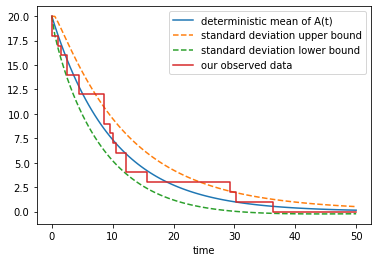

In [6]:
mean = model.mean(real_parameters, times)
variance = model.variance(real_parameters, times)
std_dev = np.sqrt(variance)

plt.plot(times, mean, '-', label = 'deterministic mean of A(t)')
plt.plot(times, mean + std_dev, '--', label = 'standard deviation upper bound')
plt.plot(times, mean - std_dev, '--', label = 'standard deviation lower bound')

plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

We now create a Sequential ABC Controller, this takes a number of optional parameters but left as default it will carry out the Toni 2019 ABC-SMC sampling algorithm

In [7]:
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

In [8]:
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([3,1.5,1]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_target(200)

# log to screen
abc.set_log_to_screen(True)

# %lprun -f abc._calculate_weights 
samples = abc.run()
print('Done!')

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=1.5
Trying t=2, threshold=1.0
Iter. Eval. Acceptance rate Time m:s
1     1607   0.000622277536   0:06.6
2     1744   0.00114678899    0:06.7
3     1999   0.00150075038    0:06.9
20    2750   0.00727272727    0:07.5
40    3773   0.0106016433     0:08.3
60    5776   0.0103878116     0:10.0
80    7177   0.0111467187     0:11.3
100   8337   0.0119947223     0:12.3
120   9315   0.0128824477     0:13.0
140   10382  0.0134848777     0:13.7
160   11384  0.0140548138     0:14.4
180   12766  0.014099953      0:15.7
200   14659  0.0136434955     0:16.9
Halting: target number of samples (200) reached.
Done!


We can then see how our series of intermediate distributions did at approximating the actual parameters by plotting them as histograms

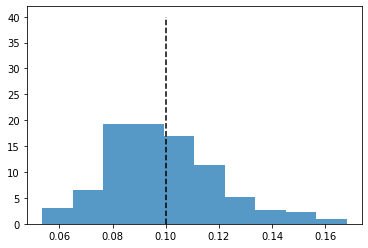

In [12]:
kwargs = dict(alpha=0.75, density=True, stacked=True)

plt.hist([x[0] for x in samples], **kwargs)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=40)
plt.show()

_or if you have seaborn installed we can see a prettier version here_

Now we can compare the recovered parameters to the real parameters used to generate this data

Observed params: [0.0966588]
Actual params: [0.1]


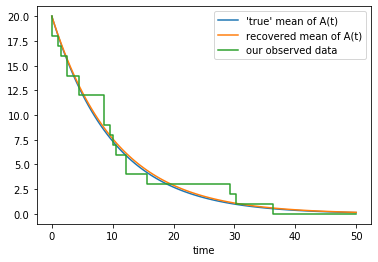

In [14]:
import statistics
observed_k = statistics.median(samples)
print("Observed params: " + str(observed_k))
print("Actual params: " + str(model.suggested_parameters()))
observed_mean = model.mean(observed_k, times)
true_mean = model.mean(model.suggested_parameters(),times)

plt.plot(times, true_mean, '-', label = "'true' mean of A(t)")
plt.plot(times, observed_mean, '-', label = 'recovered mean of A(t)')
plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

Compare this to using normal ABC-Rejection

In [15]:
abc = pints.ABCController(error_measure, log_prior, pints.RejectionABC)
# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_target(200)
# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     87     0.0114942529     0:00.1
2     304    0.00657894737    0:00.2
3     705    0.00425531915    0:00.3
20    3756   0.00532481363    0:01.6
40    8208   0.00487329435    0:03.7
60    13150  0.00456273764    0:05.7
80    17483  0.00457587371    0:07.3
100   20740  0.00482160077    0:08.6
120   23584  0.00508819539    0:09.7
140   27264  0.00513497653    0:11.3
160   31267  0.00511721623    0:13.0
180   34360  0.00523864959    0:14.4
200   37230  0.00537201182    0:15.6
Halting: target number of samples (200) reached.
Done!


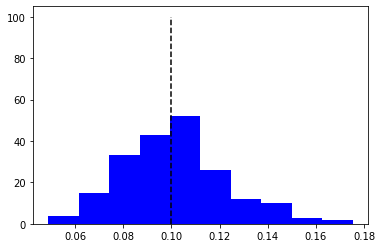

In [16]:
plt.hist(samples[:,0], color="blue")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=100)
plt.show()